In [1]:
import torch, torchvision
from torch.utils.cpp_extension import CUDA_HOME; 

#check versions and CUDA
print(torch.__version__)
!gcc --version
print(torch.version.cuda)
print(torch.cuda.is_available(), CUDA_HOME)

1.8.1
gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-44)
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

10.1
True /usr/local/cuda


In [2]:
import sys
sys.path

['/nemo/lab/briscoej/home/users/ritot/nucleus_t18/Nucleus/notebooks',
 '/camp/home/ritot/home/users/ritot/nucleus_t18/nucleys_t18/lib/python37.zip',
 '/camp/home/ritot/home/users/ritot/nucleus_t18/nucleys_t18/lib/python3.7',
 '/camp/home/ritot/home/users/ritot/nucleus_t18/nucleys_t18/lib/python3.7/lib-dynload',
 '',
 '/camp/home/ritot/.local/lib/python3.7/site-packages',
 '/camp/home/ritot/home/users/ritot/nucleus_t18/nucleys_t18/lib/python3.7/site-packages',
 '/camp/home/ritot/home/users/ritot/nucleus_t18/nucleys_t18/lib/python3.7/site-packages/IPython/extensions',
 '/nemo/project/home/ritot/.ipython']

In [3]:
sys.executable

'/camp/home/ritot/home/users/ritot/nucleus_t18/nucleys_t18/bin/python3.7'

In [4]:
# there is a detectron wrong version somwhr.. make sure path is only the env one

# sys.path.remove('/camp/lab/briscoej/working/tiago/nucleus_test1/Nucleus/notebooks')
sys.path.remove('/camp/home/ritot/.local/lib/python3.7/site-packages')
#sys.path.remove('/camp/home/ritot/.ipython')
sys.path.remove('')

In [5]:
%load_ext autoreload
%autoreload 2

# import common libraries
import numpy as np
import cv2
import os
import random
import matplotlib.pylab as plt
from PIL import Image
import tqdm 
import timeit
import time
import pandas as pd
from math import floor

# import some detectron2 utilities
import detectron2
print(detectron2.__version__)
import sys
sys.path.append('../')

from Nucleus import ImageInput
from Nucleus import ImageTile
from Nucleus import Stitcher
from detectron2_predict import detectron_predict
from detectron2_predict import detectron_init
from utils import PNG_to_JSON
from utils import PNG_to_JSON
from utils import tools_3d
from Nucleus import coco_nucleus
from skimage import io
import networkx as nx


0.4
Nucleus
utils.PNG_to_JSON


In [7]:
ROOT_PATH = "/nemo/lab/briscoej/home/users/ritot/nucleus_t18/Nucleus/notebooks/YAP_3d_n2/" 
ROOT_PATH = "/camp/home/ritot/home/shared/tiago-ashley/HCR5/crop_hcr5/" 

#there should be a img and masks folders inside ROOT_PATH.

NUCLEAR_Ch = 0 # zero-indexed => 0 corresponds to channel 1

#lists all images to be segmented
images_to_segment = os.listdir(ROOT_PATH+"/img/")

images_to_segment = [name for name in images_to_segment if 'tif' in name]
images_to_segment = [x for x in images_to_segment if ("crop" in x)]

print(images_to_segment)
print(len(images_to_segment))

['hcr_03-12-24.lif - hcr 1 Merged crop.tif']
1


In [8]:
if not os.path.isdir(ROOT_PATH+"/masks/"):
    os.makedirs(ROOT_PATH+"/masks/")

input_img=images_to_segment[0]
print(input_img)
im = io.imread(ROOT_PATH+"img/"+input_img)
im = np.moveaxis(im, -1, 1)   #z, channel, x, y

print(im.shape) #verify shape always!

hcr_03-12-24.lif - hcr 1 Merged crop.tif
(263, 4, 1564, 3528)


In [9]:
## all the stuff to predict masks

# suffle channels around if needed: (z-planes, channels, x, y)
#im = np.moveaxis(im, -1, 1)
print(im.shape)

im = im[:,:,0:floor(im.shape[2]/128)*128,0:floor(im.shape[3]/128)*128]
print(im.shape)

(263, 4, 1564, 3528)
(263, 4, 1536, 3456)


In [10]:

#for z in tqdm.notebook.tqdm(range(im.shape[0]), desc="z-planes to segment"):
for z in range(im.shape[0]):
#for z in range(92,212):
    print("Segmenting image:")
    print(z)

    sz=im[z,NUCLEAR_Ch,:,:] # im[z,:,:,0] #why this difference? tiff format?
    print(sz.shape)

    # interpolate image to higher size 
    #sz= cv2.resize(sz, (0,0), fx=2, fy=2, interpolation=cv2.INTER_LANCZOS4) # just for predictor
    #im = Image.fromarray(sz) # do not save
    #input_img = input_img+"_mod.tif"
    #im.save(ROOT_PATH+"/img/"+input_img)

    one = ImageInput(img_str=sz, step=128) 
    #one.show_me()



    # split image in tiles for 'stitch_v1' 
    m_tiles, v_tiles, h_tiles = one.make_tiles('stitch_v1')

    #just shows an example
    #m_tiles[4].show_me()

    print(np.shape(m_tiles[7].img))



    # Predicting for : 'stitch_v1'
    print("Predicting...")

    pred= detectron_init(model='SC_sections') # 'invitro'  or 'SC_sections'

    tic=timeit.default_timer()
    print("Main_tiles")
    m_out = [detectron_predict(_im,pred) for _im in m_tiles] 
    print("V_tiles")
    v_out = [detectron_predict(_im,pred) for _im in v_tiles]
    print("H_tiles")
    h_out = [detectron_predict(_im,pred) for _im in h_tiles]
    toc=timeit.default_timer()
    #print('The time was {:.2f} sec'.format(toc - tic))

    # Stitching
    print("Stitching...")
    tic=timeit.default_timer()
    test = Stitcher(one)
    seg_mask, nuclei_tally = test.stitch_v1([m_tiles,v_tiles,h_tiles] , [m_out, v_out, h_out], margin=5)
    toc=timeit.default_timer()
    #print('The time was {:.2f} sec'.format(toc - tic))
    #plt.figure(figsize=(8,8))
    #plt.imshow(seg_mask)
    print(f'This image has {nuclei_tally} segmented nuclei.')
    
    
    
    # save mask 
    print("Saving...")
    #im = cv2.resize(seg_mask, (0,0), fx=0.5, fy=0.5, interpolation=cv2.INTER_NEAREST) #scale mask to fit original input
    #im = Image.fromarray(im)
    im_seg = Image.fromarray(seg_mask)
    im_seg.save(ROOT_PATH+"masks/z"+f"{z:03d}"+"z_"+input_img)
    
    
    
    
#     # save JSON
#     tic=timeit.default_timer()
#     PNG_to_JSON.main(ROOT_DIR=ROOT_PATH,
#                             image_files=[input_img], z_slice=z,
#                             output= ROOT_PATH+"masks/z"+f"{z:03d}"+"z_"+input_img +'_.json') 
#     toc=timeit.default_timer()
#     print('The time for saving json was {:.2f} sec'.format(toc - tic))
    
    
    
#     # save overlay segmentation and image
#     segmFile =ROOT_PATH+"masks/z"+f"{z:03d}"+"z_"+input_img+'_.json'
#     imgDir   = ROOT_PATH+"img/"
#     output_imageFile = ROOT_PATH+"masks/z"+f"{z:03d}"+"z_"+input_img+'_coco_out.png'
#     pick_image_number=0
    
#     coco=coco_nucleus(segmFile)
#     cats = coco.loadCats(coco.getCatIds())
#     nms=[cat['name'] for cat in cats]
#     print('COCO categories: \n{}\n'.format(' '.join(nms)))
#     catIds = coco.getCatIds(catNms=['nucleus']);
#     imgIds = coco.getImgIds(catIds=catIds);
#     img = coco.loadImgs(imgIds[pick_image_number])[0]
    
#     fig = plt.figure(figsize=(18,18))
    
#     I = io.imread(imgDir+img['file_name'])
#     I = np.asarray(I[z,NUCLEAR_Ch,:,:]) #[z,:,:,0]
    
    
#     plt.imshow(I, cmap='magma'); plt.axis('off')
#     annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
#     anns = coco.loadAnns(annIds)
#     coco.showAnns_Nucleus(anns)
#     plt.savefig(output_imageFile,dpi=150,bbox_inches='tight',pad_inches=0)
#     plt.close()
    

Segmenting image:
0
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 127 segmented nuclei.
Saving...
Segmenting image:
1
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 111 segmented nuclei.
Saving...
Segmenting image:
2
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 140 segmented nuclei.
Saving...
Segmenting image:
3
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border ti

Main_tiles
V_tiles
H_tiles
Stitching...
This image has 721 segmented nuclei.
Saving...
Segmenting image:
30
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 747 segmented nuclei.
Saving...
Segmenting image:
31
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 785 segmented nuclei.
Saving...
Segmenting image:
32
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 806 segmented nuclei.
Saving...
Segmenting image:
33
(1536, 3456)


Main_tiles
V_tiles
H_tiles
Stitching...
This image has 1824 segmented nuclei.
Saving...
Segmenting image:
58
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 1866 segmented nuclei.
Saving...
Segmenting image:
59
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 1897 segmented nuclei.
Saving...
Segmenting image:
60
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 1926 segmented nuclei.
Saving...
Segmenting image:
61
(1536, 34

Main_tiles
V_tiles
H_tiles
Stitching...
This image has 3523 segmented nuclei.
Saving...
Segmenting image:
86
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 3546 segmented nuclei.
Saving...
Segmenting image:
87
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 3608 segmented nuclei.
Saving...
Segmenting image:
88
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 3641 segmented nuclei.
Saving...
Segmenting image:
89
(1536, 34

Main_tiles
V_tiles
H_tiles
Stitching...
This image has 4831 segmented nuclei.
Saving...
Segmenting image:
115
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 4843 segmented nuclei.
Saving...
Segmenting image:
116
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 4864 segmented nuclei.
Saving...
Segmenting image:
117
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 4840 segmented nuclei.
Saving...
Segmenting image:
118
(1536

Main_tiles
V_tiles
H_tiles
Stitching...
This image has 5181 segmented nuclei.
Saving...
Segmenting image:
143
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 5098 segmented nuclei.
Saving...
Segmenting image:
144
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 5054 segmented nuclei.
Saving...
Segmenting image:
145
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 4957 segmented nuclei.
Saving...
Segmenting image:
146
(1536

Main_tiles
V_tiles
H_tiles
Stitching...
This image has 4556 segmented nuclei.
Saving...
Segmenting image:
171
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 4575 segmented nuclei.
Saving...
Segmenting image:
172
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 4596 segmented nuclei.
Saving...
Segmenting image:
173
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 4552 segmented nuclei.
Saving...
Segmenting image:
174
(1536

Main_tiles
V_tiles
H_tiles
Stitching...
This image has 4154 segmented nuclei.
Saving...
Segmenting image:
199
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 4243 segmented nuclei.
Saving...
Segmenting image:
200
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 4204 segmented nuclei.
Saving...
Segmenting image:
201
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 4175 segmented nuclei.
Saving...
Segmenting image:
202
(1536

Main_tiles
V_tiles
H_tiles
Stitching...
This image has 3878 segmented nuclei.
Saving...
Segmenting image:
227
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 3859 segmented nuclei.
Saving...
Segmenting image:
228
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 3953 segmented nuclei.
Saving...
Segmenting image:
229
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 3464 segmented nuclei.
Saving...
Segmenting image:
231
(1536

V_tiles
H_tiles
Stitching...
This image has 3835 segmented nuclei.
Saving...
Segmenting image:
256
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 3856 segmented nuclei.
Saving...
Segmenting image:
257
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 3814 segmented nuclei.
Saving...
Segmenting image:
258
(1536, 3456)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
(128, 128, 3)
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 3887 segmented nuclei.
Saving...
Segmenting image:
259
(1536, 3456)
Usi

(263, 1564, 3528, 4)
(263, 1564, 3528, 0)
(263, 1536, 3456)
(263, 1536, 3456)


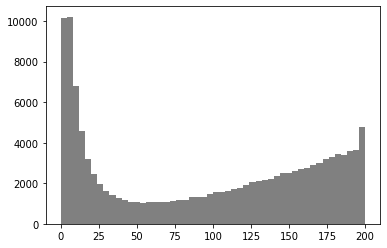

In [11]:
masks,df = tools_3d.make_3d_mask(ROOT_PATH, input_img, top_range=200) #histogram range 0-top

In [12]:
cutoff = 50 # filter small nuclei

masks = tools_3d.filter_and_save_3d_mask(masks, df, cutoff, ROOT_PATH, input_img)


Saved npz with collection of 2D masks with small areas filtered out.
/camp/home/ritot/home/shared/tiago-ashley/HCR5/crop_hcr5/hcr_03-12-24.lif - hcr 1 Merged crop.tif_masks_merge_no_small.npz


In [13]:
masks.shape

(263, 1536, 3456)

Number of labels: 1000


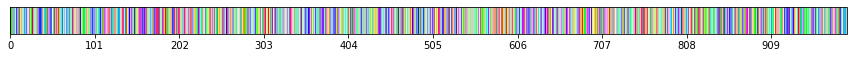

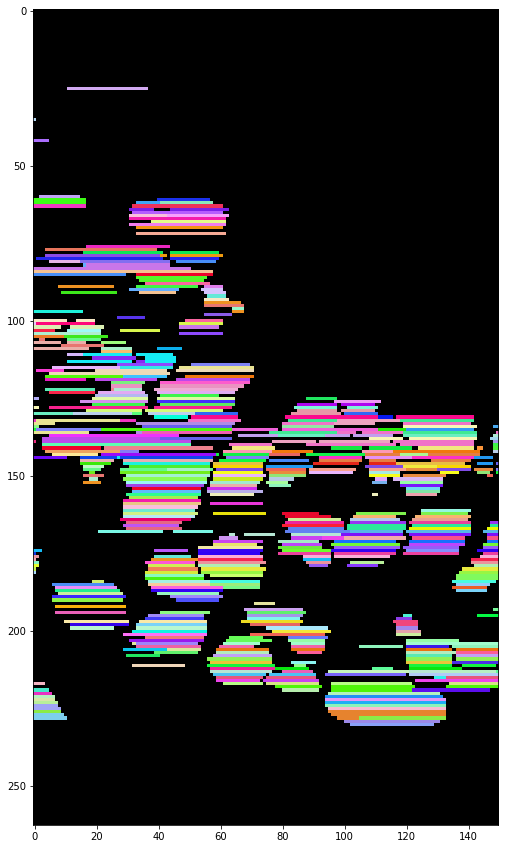

In [14]:
new_cmap = tools_3d.rand_cmap(1000, type='bright', first_color_black=True, last_color_black=False, verbose=True)


plt.figure(figsize=(17,15))
plt.imshow(np.flip(masks[:,600:750,650],axis=0), cmap=new_cmap, interpolation='none');# plt.axis('off')


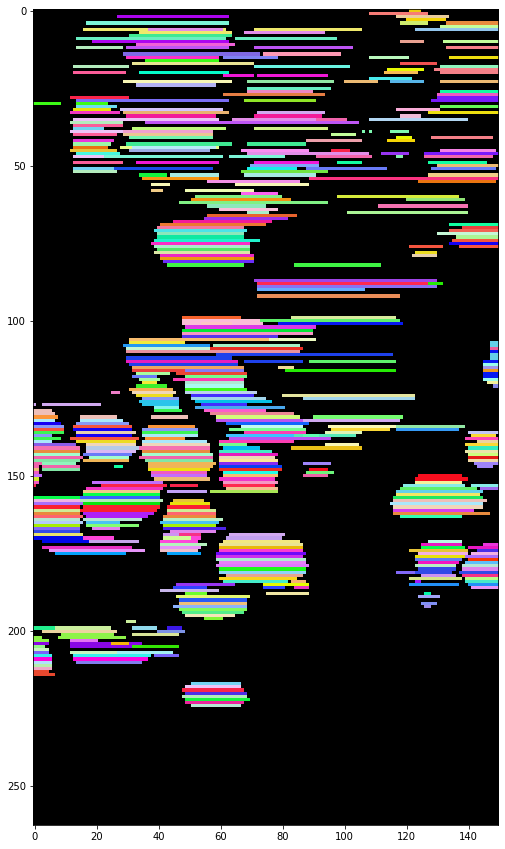

In [15]:

plt.figure(figsize=(15,15))
plt.imshow(np.flip(masks[:,700:850,350],axis=0), cmap=new_cmap, interpolation='none');


In [16]:
#build a graph linking nuclei across z

tic = time.perf_counter()
to_add = tools_3d.graph_contructor(masks)
G = nx.DiGraph()
to_add2=[tuple(x[0]) for x in to_add if not x==[]]
G.add_edges_from(to_add2)
nx.write_gpickle(G, ROOT_PATH+input_img+"G.gpickle")
toc = time.perf_counter()

print(f"Done in {toc - tic:0.4f} seconds")


Done in 4139.6995 seconds


Total number of nuclei in the stack (connected components):
50576
10.0
Percentage of nuclei too big:
36
Absolute number
18294


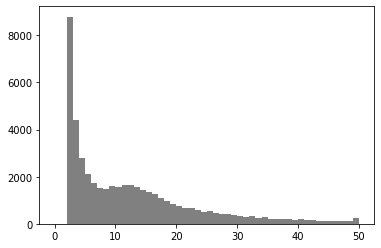

In [17]:
G = nx.read_gpickle(ROOT_PATH+input_img+"G.gpickle")
masks = np.load(ROOT_PATH+input_img+"_masks_merge_no_small.npz")
masks = masks['arr_0']


nuclei = tools_3d.graph_stats(G)


#select threshold above which to partition graph and put split nuclei into main dic (median+2 as a first pass?)
graph_par_thres = 14



nodes_per_nucleus = {}  
for i in nuclei.keys():
    nodes_per_nucleus[i]=len(list(nuclei[i]))
print("Percentage of nuclei too big:")
print(int(np.sum([ x > graph_par_thres for x in nodes_per_nucleus.values()]) *100 / len(nodes_per_nucleus.values())))
print("Absolute number")
print(int(np.sum([ x > graph_par_thres for x in nodes_per_nucleus.values()])))



In [18]:
hard_cutoff = 30 #nothing about graph_par_thres+hard_cutoff
nuclei = tools_3d.consolidate(G, masks, nuclei, graph_par_thres,hard_cutoff)

Total number of nuclei in the stack:
50576
Nuclei to split:
18294
Total number of nuclei in the stack:
96797
Nuclei to further split
1782


Nuclei to further split
1191


Nuclei to further split
948


Nuclei to further split
838


Nuclei to further split
806


Nuclei to further split
800


Nuclei to further split
798


Nuclei to further split
795


Nuclei to further split
795




Total number of nuclei in the stack:
98650




17067
5.0
8.132184490623416


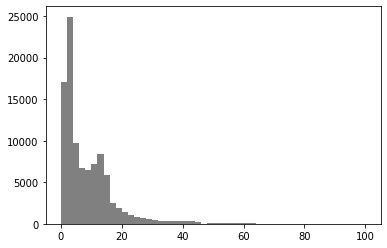

In [19]:
nodes_per_nucleus = {}  
for i in nuclei.keys():
    nodes_per_nucleus[i]=len(list(nuclei[i]))
    
print(np.sum([x<2 for x in list(nodes_per_nucleus.values())]))

_ = plt.hist(nodes_per_nucleus.values(), 50, range=[0,100], facecolor='grey')
print(np.median(list(nodes_per_nucleus.values())))
print(np.mean(list(nodes_per_nucleus.values())))

In [20]:
start = time.time()
masks_3d = tools_3d.make_3d_mat(nuclei, masks)
masks_3d = masks_3d.get()
end = time.time()

np.savez_compressed(ROOT_PATH+"mask_3d_"+input_img+".npz", masks_3d)

print("Took %f min" % ((end - start) / 60.0) )


Took 85.626512 min


In [21]:
masks_3d.shape

(263, 1536, 3456)

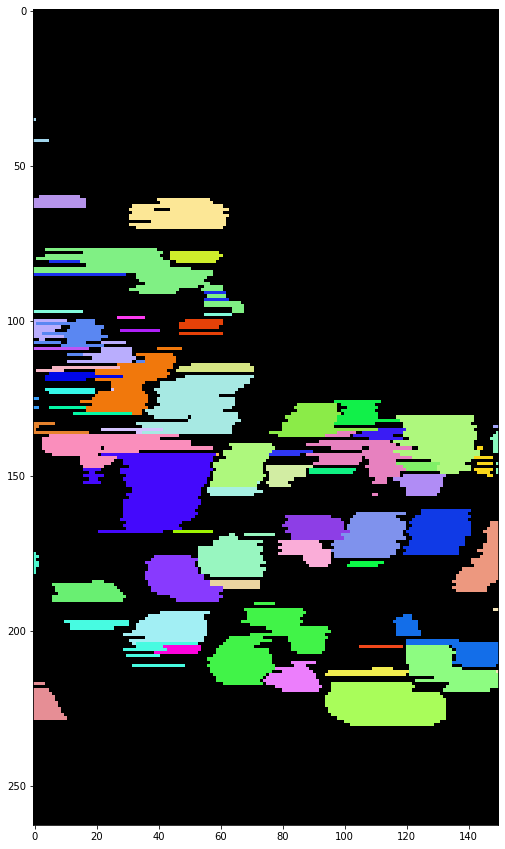

In [22]:

plt.figure(figsize=(17,15))
plt.imshow(np.flip(masks_3d[:,600:750,650],axis=0), cmap=new_cmap, interpolation='none');# plt.axis('off')


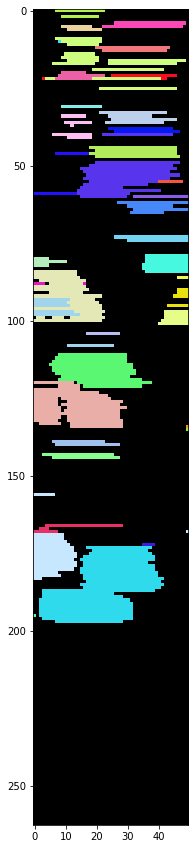

In [23]:
plt.figure(figsize=(15,15))
plt.imshow(np.flip(masks_3d[:,500:550,250],axis=0), cmap=new_cmap, interpolation='none');

In [24]:
print(input_img)
im = io.imread(ROOT_PATH+"img/"+input_img)
print(im.shape) # should be (z, channels, x,y)
im = np.moveaxis(im, -1, 1) #may need to be commented
im = im[:,:,0:floor(im.shape[2]/128)*128,0:floor(im.shape[3]/128)*128]
print(im.shape)


data = np.load(ROOT_PATH+"mask_3d_"+input_img+".npz")
masks_3d = data['arr_0']
print(masks_3d.shape)

tic = time.perf_counter()
result = tools_3d.get_feature_table(input_img, im, masks_3d)
toc = time.perf_counter()
print(f"Done in {toc - tic:0.4f} seconds")


Data = pd.DataFrame(result, columns=('Image','Instance','Volume','Center Mass',
                                 'nuclear_avgs','hood_avgs','cyto_avgs',)
                   )

output_table = ROOT_PATH + input_img + "_3D_nuclei_features_table_fullstack.csv"
Data.to_csv(output_table, index=False)
Data

print("Done!")

hcr_03-12-24.lif - hcr 1 Merged crop.tif
(263, 1564, 3528, 4)
(263, 4, 1536, 3456)
(263, 1536, 3456)
Done in 105931.3949 seconds
Done!


In [26]:
print("Done!")


Done!


In [ ]:
!ls

20.01.2024_YAP_verterporfin.lif - GFP_631Position 2.tif
(12, 1024, 5, 1024)
(12, 5, 1024, 1024)
(12, 5, 1024, 1024)
(12, 1024, 1024)
(12, 1024, 1024)
Saved npz with collection of 2D masks with small areas filtered out.
/nemo/lab/briscoej/home/users/ritot/nucleus_t18/Nucleus/notebooks/YAP_3d_n2/20.01.2024_YAP_verterporfin.lif - GFP_631Position 2.tif_masks_merge_no_small.npz
Done in 10.0955 seconds
Total number of nuclei in the stack (connected components):
1246
5.0
Percentage of nuclei too big:
1
Absolute number
20
Total number of nuclei in the stack:
1246
Nuclei to split:
20
Total number of nuclei in the stack:
1274
Nuclei to further split
0




Total number of nuclei in the stack:
1274


6
5.0
5.384615384615385
Took 2822.592020 ms
20.01.2024_YAP_verterporfin.lif - GFP_631Position 2.tif
(12, 5, 1024, 1024)
(12, 5, 1024, 1024)
Done in 11.1478 seconds
20.01.2024_YAP_verterporfin.lif - GFP_631Position 7.tif
(12, 1024, 5, 1024)
(12, 5, 1024, 1024)
(12, 5, 1024, 1024)
(12, 1024, 1024)
(

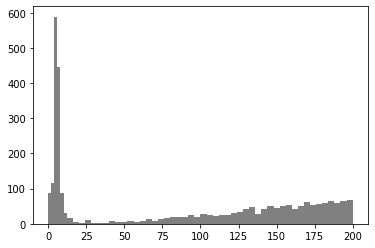

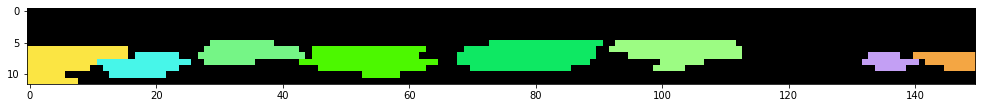

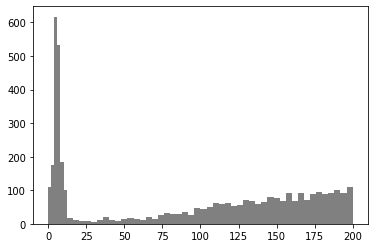

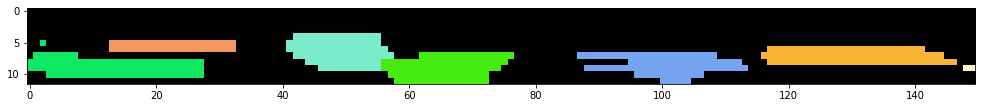

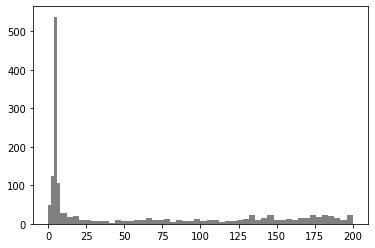

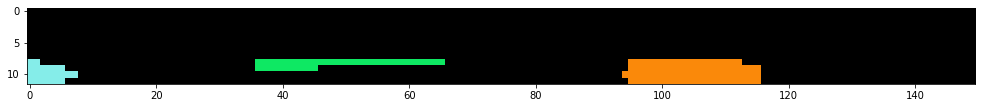

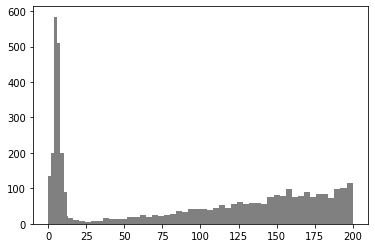

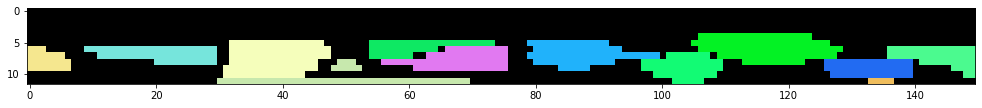

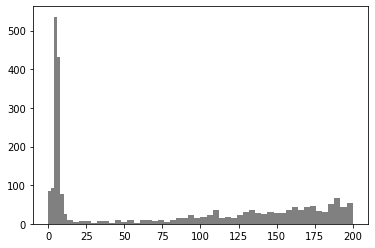

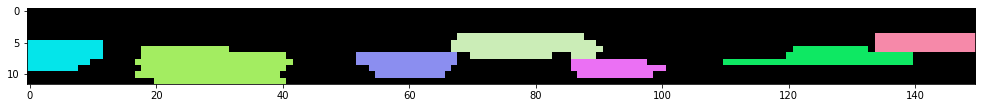

In [117]:
# batch mode


for img_in in range(6,11):
    
    input_img=images_to_segment[img_in]
    print(input_img)
    im = io.imread(ROOT_PATH+"img/"+input_img)
    im = np.moveaxis(im, -1, 1)   #z, channel, x, y
    print(im.shape)
    
    masks,df = tools_3d.make_3d_mask(ROOT_PATH, input_img,top_range=200) #histogram range 0-top
    
    cutoff = 50 # filter small nuclei
    masks = tools_3d.filter_and_save_3d_mask(masks, df, cutoff, ROOT_PATH, input_img)
    
    #build a graph linking nuclei across z
    tic = time.perf_counter()
    to_add = tools_3d.graph_contructor(masks)
    G = nx.DiGraph()
    to_add2=[tuple(x[0]) for x in to_add if not x==[]]
    G.add_edges_from(to_add2)
    nx.write_gpickle(G, ROOT_PATH+input_img+"G.gpickle")
    toc = time.perf_counter()
    print(f"Done in {toc - tic:0.4f} seconds")


    G = nx.read_gpickle(ROOT_PATH+input_img+"G.gpickle")
    masks = np.load(ROOT_PATH+input_img+"_masks_merge_no_small.npz")
    masks = masks['arr_0']


    nuclei = tools_3d.graph_stats(G)

    #select threshold above which to partition graph and put split nuclei into main dic (median+2 as a first pass?)
    graph_par_thres = 10
    nodes_per_nucleus = {}  
    for i in nuclei.keys():
        nodes_per_nucleus[i]=len(list(nuclei[i]))
    print("Percentage of nuclei too big:")
    print(int(np.sum([ x > graph_par_thres for x in nodes_per_nucleus.values()]) *100 / len(nodes_per_nucleus.values())))
    print("Absolute number")
    print(int(np.sum([ x > graph_par_thres for x in nodes_per_nucleus.values()])))


    hard_cutoff = 12 #nothing about graph_par_thres+hard_cutoff
    nuclei = tools_3d.consolidate(G, masks, nuclei, graph_par_thres,hard_cutoff)

    nodes_per_nucleus = {}  
    for i in nuclei.keys():
        nodes_per_nucleus[i]=len(list(nuclei[i]))

    print(np.sum([x<2 for x in list(nodes_per_nucleus.values())]))

    _ = plt.hist(nodes_per_nucleus.values(), 50, range=[0,100], facecolor='grey')
    print(np.median(list(nodes_per_nucleus.values())))
    print(np.mean(list(nodes_per_nucleus.values())))

    start = time.time()
    masks_3d = tools_3d.make_3d_mat(nuclei, masks)
    masks_3d = masks_3d.get()
    end = time.time()
    np.savez_compressed(ROOT_PATH+"mask_3d_"+input_img+".npz", masks_3d)
    print("Took %f ms" % ((end - start) * 1000.0) )
    
    plt.figure(figsize=(17,15))
    plt.imshow(np.flip(masks_3d[:,600:750,650],axis=0), cmap=new_cmap, interpolation='none');# plt.axis('off')

    print(input_img)
    im = io.imread(ROOT_PATH+"img/"+input_img)
    print(im.shape) # should be (z, channels, x,y)
    #im = np.moveaxis(im, -1, 1) #may need to be commented
    print(im.shape)
    data = np.load(ROOT_PATH+"mask_3d_"+input_img+".npz")
    masks_3d = data['arr_0']
    masks_3d.shape

    tic = time.perf_counter()
    result = tools_3d.get_feature_table(input_img, im, masks_3d)
    toc = time.perf_counter()
    print(f"Done in {toc - tic:0.4f} seconds")


    Data = pd.DataFrame(result, columns=('Image','Instance','Volume','Center Mass',
                                     'nuclear_avgs','hood_avgs','cyto_avgs',)
                       )

    output_table = ROOT_PATH + input_img + "_3D_nuclei_features_table_fullstack.csv"
    Data.to_csv(output_table, index=False)
    Data

Text(0.5, 1.0, 'Volume (px)')

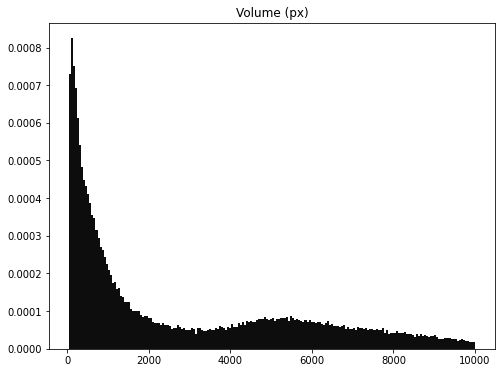

In [39]:
plt.figure(figsize=(8,6))
plt.hist(Data['Volume'][Data.Volume<10000], 200, density=True, facecolor='black', alpha=0.95)
plt.title('Volume (px)')

In [32]:
Data[Data.Volume>20000]

,Image,Instance,Volume,Center Mass,nuclear_avgs,hood_avgs,cyto_avgs
13896,crop_hcr3_03-12-24-merged.lif - TileScan 2_Mer...,13897,21130,"(73.0, 888.0, 2044.0)","[16.46, 17.622, 0.541, 8.937]","[19.664, 20.662, 0.754, 12.666]","[24.071, 24.845, 1.047, 17.797]"
18461,crop_hcr3_03-12-24-merged.lif - TileScan 2_Mer...,18462,20818,"(91.0, 824.0, 3966.0)","[12.467, 13.867, 0.293, 3.589]","[14.04, 14.659, 0.326, 4.644]","[14.931, 15.107, 0.344, 5.241]"
20505,crop_hcr3_03-12-24-merged.lif - TileScan 2_Mer...,20506,20061,"(101.0, 831.0, 3965.0)","[11.981, 13.649, 0.279, 2.951]","[13.122, 14.233, 0.302, 3.353]","[13.783, 14.571, 0.315, 3.586]"
23025,crop_hcr3_03-12-24-merged.lif - TileScan 2_Mer...,23026,21291,"(114.0, 453.0, 1919.0)","[12.512, 12.743, 0.329, 3.283]","[13.676, 13.334, 0.425, 3.488]","[14.347, 13.674, 0.48, 3.607]"
27588,crop_hcr3_03-12-24-merged.lif - TileScan 2_Mer...,27589,62345,"(143.0, 1151.0, 3907.0)","[14.405, 14.724, 0.576, 3.619]","[15.904, 15.501, 1.073, 3.753]","[17.209, 16.176, 1.505, 3.869]"
...,...,...,...,...,...,...,...
90170,crop_hcr3_03-12-24-merged.lif - TileScan 2_Mer...,90171,25656,"(159.0, 621.0, 2382.0)","[102.002, 38.088, 16.825, 6.115]","[88.65, 36.576, 19.042, 6.187]","[74.377, 34.959, 21.412, 6.264]"
90175,crop_hcr3_03-12-24-merged.lif - TileScan 2_Mer...,90176,21019,"(17.0, 71.0, 2768.0)","[82.619, 39.782, 1.227, 4.922]","[69.853, 38.082, 1.261, 4.951]","[49.86, 35.421, 1.315, 4.996]"
90176,crop_hcr3_03-12-24-merged.lif - TileScan 2_Mer...,90177,23292,"(36.0, 501.0, 1047.0)","[69.975, 41.47, 3.701, 7.944]","[61.102, 42.295, 4.088, 9.142]","[46.418, 43.661, 4.728, 11.123]"
90191,crop_hcr3_03-12-24-merged.lif - TileScan 2_Mer...,90192,22458,"(107.0, 638.0, 1915.0)","[87.313, 39.244, 12.807, 12.404]","[75.201, 39.419, 15.094, 14.332]","[62.119, 39.608, 17.563, 16.414]"


In [29]:
Data = pd.read_csv(ROOT_PATH+input_img+"_3D_nuclei_features_table_fullstack.csv")
Data

,Image,Instance,Volume,Center Mass,nuclear_avgs,hood_avgs,cyto_avgs
0,crop_hcr3_03-12-24-merged.lif - TileScan 2_Mer...,1,4130,"(4.0, 41.0, 40.0)","[44.63, 21.673, 0.679, 3.095]","[34.972, 19.509, 0.682, 3.115]","[20.319, 16.226, 0.687, 3.145]"
1,crop_hcr3_03-12-24-merged.lif - TileScan 2_Mer...,2,847,"(1.0, 18.0, 94.0)","[54.235, 23.116, 0.877, 3.57]","[41.521, 20.892, 0.987, 3.557]","[30.633, 18.987, 1.082, 3.546]"
2,crop_hcr3_03-12-24-merged.lif - TileScan 2_Mer...,3,2187,"(2.0, 66.0, 77.0)","[44.072, 20.64, 0.795, 2.95]","[33.817, 18.972, 0.797, 3.097]","[22.368, 17.109, 0.799, 3.261]"
3,crop_hcr3_03-12-24-merged.lif - TileScan 2_Mer...,4,2415,"(4.0, 53.0, 7.0)","[56.795, 24.885, 1.31, 3.316]","[45.298, 22.852, 1.35, 3.359]","[27.464, 19.698, 1.412, 3.426]"
4,crop_hcr3_03-12-24-merged.lif - TileScan 2_Mer...,5,1999,"(6.0, 4.0, 12.0)","[54.646, 23.598, 0.774, 3.344]","[43.687, 20.894, 0.707, 3.147]","[28.547, 17.158, 0.614, 2.876]"
...,...,...,...,...,...,...,...
90192,crop_hcr3_03-12-24-merged.lif - TileScan 2_Mer...,90193,853,"(81.0, 638.0, 1918.0)","[49.664, 40.376, 3.226, 30.42]","[49.47, 39.586, 3.062, 27.751]","[49.416, 39.365, 3.016, 27.005]"
90193,crop_hcr3_03-12-24-merged.lif - TileScan 2_Mer...,90194,17311,"(132.0, 643.0, 1684.0)","[78.776, 38.559, 19.506, 7.918]","[67.961, 37.833, 20.565, 8.259]","[55.928, 37.024, 21.744, 8.639]"
90194,crop_hcr3_03-12-24-merged.lif - TileScan 2_Mer...,90195,10484,"(110.0, 640.0, 1696.0)","[83.199, 37.778, 3.754, 8.834]","[75.143, 37.048, 3.84, 10.098]","[67.836, 36.387, 3.918, 11.244]"
90195,crop_hcr3_03-12-24-merged.lif - TileScan 2_Mer...,90196,13918,"(18.0, 639.0, 990.0)","[60.122, 38.238, 4.203, 8.686]","[53.43, 37.593, 4.392, 8.918]","[44.235, 36.706, 4.652, 9.236]"


Text(0.5, 1.0, 'Volume (px)')

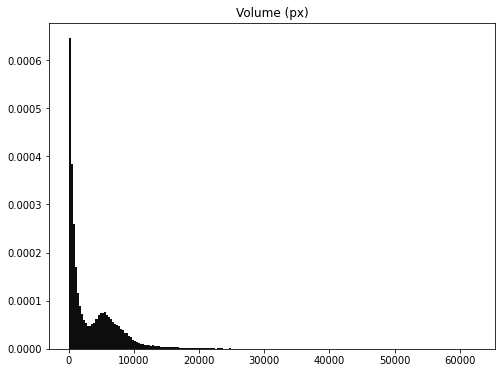

In [30]:
plt.figure(figsize=(8,6))
plt.hist(Data['Volume'], 200, density=True, facecolor='black', alpha=0.95)
plt.title('Volume (px)')
#plt.xlim(0,15000)

In [83]:
tools_3d.export_3d_array_rgb(masks_3d, ROOT_PATH+input_img+'masks_colorful_paper.tif')

(103, 1024, 1024)

Unique nuclei ids in image:
2880
dimensions: (103, 1024, 1024, 3)
exported rgb tif file to /camp/lab/briscoej/working/tiago/nucleus_t18/Nucleus/notebooks/YAP_3d/tifs_48h/YAP_TBXT_48h_7.10.2022.lif - 40X_48h_n1.tifmasks_colorful_paper.tif
done!


In [84]:
# look at a specific instance

#say volume of 1,500 and volume of 30,000

